In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# save filepath 
home_data_file_path = '/Users/balqeesjabri/Downloads/train.csv'
# read the data and store data in DataFrame home_data
home_data = pd.read_csv(home_data_file_path)

In [3]:
home_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Based on the charatistics of the dataset I have concluded that:
1. It is a supervised problem since the dataset includes labeled examples where each data point has a corresponding target variable( house price in this case)
2. The target variable is continuous (i.e numerical value house price), therefore, it is a regression problem

In [4]:
# print a summary of the data in Melbourne data
summary_stats = home_data.describe()
print(summary_stats)

                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ..

based on the above output:
I will utilize it to try and identify the outliers
by looking into features that have: (min,max,mean, 25th and 75th percentile) == 0

In [5]:
# Create lists to store the features with specific conditions
features_zero_min = []
features_zero_max = []
features_zero_25th_percentile = []

# Filter only numeric columns
numeric_data = home_data.select_dtypes(include=[float, int])

# Check for features with zero minimum
features_zero_min = numeric_data.columns[numeric_data.min() == 0].tolist()

# Check for features with zero maximum
features_zero_max = numeric_data.columns[numeric_data.max() == 0].tolist()

# Check for features with zero at the 25th percentile
percentile_25_zeros = numeric_data.columns[numeric_data.quantile(0.25) == 0].tolist()

# Check for features with zero at the 75th percentile
percentile_75_zeros = numeric_data.columns[numeric_data.quantile(0.75) == 0].tolist()

# Find features that satisfy both conditions
selected_features = list(set(features_zero_min) & set(percentile_25_zeros) & set(percentile_75_zeros))
print("Features with zero minimum:", features_zero_min)
print("Features with zero maximum:", features_zero_max)
print("Features with zero at the 25th percentile:", percentile_25_zeros)
print('Features',selected_features)

Features with zero minimum: ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']
Features with zero maximum: []
Features with zero at the 25th percentile: ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']
Features ['LowQualFinSF', 'ScreenPorch', 'BsmtFinSF2', 'BsmtHalfBath', 'EnclosedPorch', 'PoolArea', 'MiscVal', '3SsnPorch']


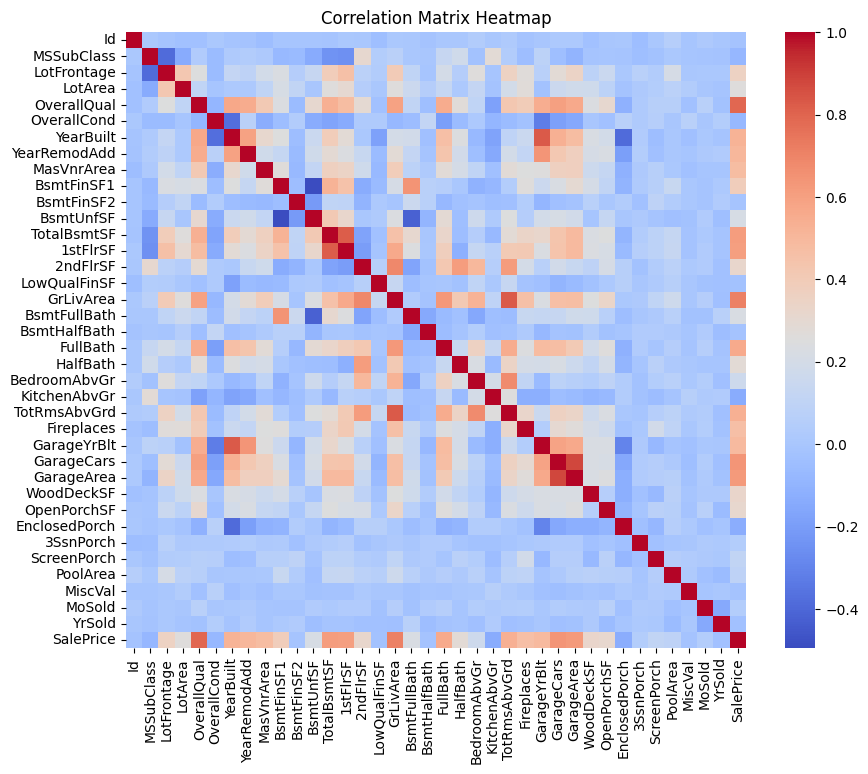

In [6]:
# CORRELATION MATRIX

# Filter only numerical columns for correlation calculation
numerical_data = home_data.select_dtypes(include=[float, int])

# Compute the correlation matrix
correlation_matrix = numerical_data.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data=correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Matrix Heatmap")
plt.show()

FROM THIS HEATMAP:
Overallqualities feature has the highest correlation, followed by,
1. GrLivArea
2. GarageCars
3. GarageArea

In [7]:
# target
y = home_data.SalePrice
X = home_data.drop(['SalePrice'], axis=1)
# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y,
                                                                random_state=0)

In [8]:
# is used to see the unique values of the target variable y (in this case, SalePrice)
print("Classes in the target variable:", np.unique(y))
avg_price = np.mean(y)
# will come in handy to see how far off is metric score
print(avg_price)

Classes in the target variable: [ 34900  35311  37900  39300  40000  52000  52500  55000  55993  58500
  60000  61000  62383  64500  66500  67000  68400  68500  72500  73000
  75000  75500  76000  76500  78000  79000  79500  79900  80000  80500
  81000  82000  82500  83000  83500  84000  84500  84900  85000  85400
  85500  86000  87000  87500  88000  89000  89471  89500  90000  90350
  91000  91300  91500  92000  92900  93000  93500  94000  94500  94750
  95000  96500  97000  97500  98000  98300  98600  99500  99900 100000
 101000 101800 102000 102776 103000 103200 103600 104000 104900 105000
 105500 105900 106000 106250 106500 107000 107400 107500 107900 108000
 108480 108500 108959 109000 109008 109500 109900 110000 110500 111000
 111250 112000 112500 113000 114500 114504 115000 116000 116050 116500
 116900 117000 117500 118000 118400 118500 118858 118964 119000 119200
 119500 119750 119900 120000 120500 121000 121500 121600 122000 122500
 122900 123000 123500 123600 124000 124500 12

In [9]:
# filter categorical cols only
categorical_cols = [colname for colname in X_train_full.columns if X_train_full[colname].dtype == "object"]

# Select numerical columns
numerical_cols = [colname for colname in X_train_full.columns if X_train_full[colname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [ ]:
# THIS STEP IS CALLED PREPROCESSING DATA
# look into missing columns and see if its missingness holds value
cols_with_missing = [col for col in X_train.columns if X_train[col].isnull().any()]
# selected_cols_with_missing = cols_with_missing.drop(['BsmtQual'], ['BsmtCond'], ['BsmtExposure'], ['BsmtFinType1'], ['BsmtFinType2'], ['GarageType'])
print(cols_with_missing)

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

# Assuming you have defined your numerical_cols and categorical_cols appropriately

# Step 1: Create transformers for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Step 2: Create a ColumnTransformer to apply different transformers to different feature types
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])


In [17]:
# # Step 2: Define the Model
# # Next, we define a random forest model with the familiar RandomForestRegressor class.
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=250, random_state=55)

1. n_estimators=100, random_state=0:  rmse: 31320.64408937722
2. n_estimators=300, random_state=0:  rmse: 31240.181525443895
3. n_estimators=300, random_state=42: rmse: 30848.3330883714
4. n_estimators=400, random_state=42  rmse: 30675.564025063748
5. n_estimators=400, random_state=55  rmse: 30068.437446816566
    - BEST SCORE:
    - n_estimators=250, random_state=55  rmse: 29866.344956563484

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create a pipline 
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])
# This line fits the pipeline to the training data,
my_pipeline.fit(X_train, y_train)

# # Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# # Evaluate the model
score = mean_absolute_error(y_valid, preds)
rmse = np.sqrt(mean_squared_error(y_valid, preds))
print('score', score)
print('rmse:', rmse)

score 16737.83459726027
rmse: 29866.344956563484
